Imports / options and main functions

In [20]:
import pandas as pd

# import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from transformers import pipeline
import re

pd.set_option('display.max_colwidth', None)


sent_pipeline = pipeline("sentiment-analysis")
data_inport = pd.read_csv(
    "../ds_final/datasets/bq_500.csv"
)  # ds_final/datasets/bq_500.csv
df = pd.DataFrame(data_inport)


# function to censor words / names in a string
def censor_words(input_string, word_list):
    words = input_string.split()
    censored_words = []
    for word in words:
        if word in word_list:
            word = "***"
        censored_words.append(word)
    censored_string = " ".join(censored_words)
    return censored_string


# function to find numbers by regex pattern
def find_numbers_by_patterns(text):
    pattern1 = r"\b\d{10}\b"
    pattern2 = r"\b\d{3}-\d{3}-\d{4}\b"
    numbers_pattern1 = re.findall(pattern1, text)
    numbers_pattern2 = re.findall(pattern2, text)
    numbers = numbers_pattern1 + numbers_pattern2
    return numbers


# function to remove following text if a specific string is found - used to clean data
def replace_matching_words(string):
    words_to_match = [
        "Sent from",
        "Sent via the",
        "<hello@colonbroom.com>",
        "<maxnutrition@kilo.health>",
        "Get Outlook for",
        "from my",
        "from Yahoo Mail",
        "From:",
        "Original message",
        "from ColonBroom",
        "wrote:",
        "Thank you,",
        "Thanks,",
        "Best regards,",
        "Best,",
        "Best ,",
        "Best regards ,",
        "Sincerly,",
        "Sincerly ,",
        "Thank you ,",
    ]
    for word in words_to_match:
        if word in string:
            word_position = string.find(word)
            string = string[:word_position] + " " * (len(string) - word_position)
    return string


# function to label user names from the string using post_tag  and ne_chunk (entity recognition (NER) from NLTK
def extract_named_entities(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Perform part-of-speech (POS) tagging
    tagged_tokens = pos_tag(tokens)

    # Perform named entity recognition (NER)
    named_entities = ne_chunk(tagged_tokens)

    # Extract the named entities from the NER result
    entities = []
    for subtree in named_entities.subtrees():
        if subtree.label() in ["PERSON"]:
            entity = " ".join([token for token, pos in subtree.leaves()])
            entities.append((entity, subtree.label()))

    return entities


def iterate_strings(dataframe):
    outside_dict = {}
    for index, row in dataframe.iterrows():
        string_value = row["message"]
        index_value = row["client_id"]
        string_value_ticket_id = row["ticket_id"]
        # Extracting names and adding it to the list for further censor function
        named_entities = extract_named_entities(string_value)
        for entity, label in named_entities:
            entity_list = entity.split()

        # Phone number annonimization
        input_text = string_value
        numbers = find_numbers_by_patterns(input_text)

        input_string = string_value
        list_adjusted = entity_list

        censored_string = replace_matching_words(
            input_string
        )  # Remove end of the strings where word maches
        censored_string_2 = censor_words(censored_string, list_adjusted)  # Censor names
        censored_string_3 = censor_words(
            censored_string_2, numbers
        )  # Censor phone numbers
        result_list = sent_pipeline(
            censored_string_3, max_length=512, truncation=True
        )  # labels and predicts
        df_2 = {
            "client_id": index_value,
            "ticket_id": string_value_ticket_id,
            "label": [],
            "score": [],
            "message": censored_string_3,
        }

        for i, d in enumerate(result_list):
            df_2.update(d)

        outside_dict[index] = df_2

    df_3 = pd.DataFrame.from_dict(outside_dict, orient="index")
    return df_3

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Sentiment analysis using distilbert-base-uncased-finetuned-sst-2-english model


In [21]:
predicted_dataframe_distilbert = iterate_strings(df)

Sentiment analysis using cardiffnlp/twitter-roberta-base-sentiment

In [10]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


def process_dataframe(data_frame):
    outside_dict = {}
    for index, row in data_frame.iterrows():
        column_value = row["message"]
        client_id_value = row["client_id"]
        ticket_id_value = row["ticket_id"]

        named_entities = extract_named_entities(column_value)
        entity_list = []

        for entity, label in named_entities:
            entity_list = entity.split()

        input_text = column_value
        numbers = find_numbers_by_patterns(input_text)

        input_string = column_value
        list_adjusted = entity_list
        censored_string = replace_matching_words(input_string) # remove unecessary words / phrases such as Sent via.
        censored_string_2 = censor_words(censored_string, list_adjusted)  # censor names
        censored_string_3 = censor_words(
            censored_string_2, numbers
        )  # censor phone numbers

        encoded_text = tokenizer(
            censored_string_3, return_tensors="pt", max_length=512, truncation=True
        )
        output = model(**encoded_text)
        score = output[0][0].detach().numpy()
        score = softmax(score)
        score_dict = {
            "ticket_id": ticket_id_value,
            "client_id": client_id_value,
            "roberta_neg": score[0],
            "roberta_neu": score[1],
            "roberta_pos": score[2],
            "message": censored_string_3,
        }
        outside_dict[index] = score_dict
    df_3 = pd.DataFrame.from_dict(outside_dict, orient="index")
    return df_3


predicted_df_roberta_base = process_dataframe(df)

Sentiment analysis using cardiffnlp/twitter-roberta-base-sentiment-latest

In [11]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

predicted_df_roberta_latest = process_dataframe(df)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sentiment analysis using siebert/sentiment-roberta-large-english

In [16]:
sent_pipeline = pipeline(
    "sentiment-analysis", model="siebert/sentiment-roberta-large-english"
)

predicted_df_siebert_large = iterate_strings(df)

In [17]:
predicted_df_siebert_large.head()

,client_id,ticket_id,label,score,message
0,9065920865937,3032762,NEGATIVE,0.997462,"Hello, My credit card just reached out and ask..."
1,9066259154321,3032871,NEGATIVE,0.999474,"Hi, I was just charged on my card for Colonbro..."
2,9072081178513,3034837,NEGATIVE,0.998743,Hi how are you Colon broom isn’t working for m...
3,9069939987345,3033933,POSITIVE,0.887546,How soon bfore I received my order plsease let...
4,9062676293521,3032000,NEGATIVE,0.999461,I meant to cancel my subscription and I receiv...


Comparing different models

In [22]:
def compare_dataframes(df1, df2):
    merged_df = pd.merge(df1, df2, on=["client_id", "ticket_id"], how="inner")
    merged_df["label_change"] = merged_df["label_x"] != merged_df["label_y"]
    merged_df["score_change"] = merged_df["score_y"] - merged_df["score_x"]

    return merged_df[
        [
            "client_id",
            "ticket_id",
            "label_x",
            "label_y",
            "label_change",
            "score_x",
            "score_y",
            "score_change",
            "message_x",
        ]
    ]


comparison_result_distilbert_siebert = compare_dataframes(predicted_dataframe_distilbert, predicted_df_siebert_large)
print(comparison_result_distilbert_siebert)

         client_id  ticket_id   label_x   label_y  label_change   score_x   
0    9065920865937    3032762  NEGATIVE  NEGATIVE         False  0.992069  \
1    9066259154321    3032871  NEGATIVE  NEGATIVE         False  0.998761   
2    9072081178513    3034837  NEGATIVE  NEGATIVE         False  0.976462   
3    9069939987345    3033933  NEGATIVE  POSITIVE          True  0.975614   
4    9062676293521    3032000  NEGATIVE  NEGATIVE         False  0.998990   
..             ...        ...       ...       ...           ...       ...   
495  9072962956177    3035276  NEGATIVE  NEGATIVE         False  0.999398   
496   392944736337    3033864  NEGATIVE  NEGATIVE         False  0.991988   
497  9064186283409    3032307  POSITIVE  POSITIVE         False  0.994371   
498  9062565377937    3031992  NEGATIVE  POSITIVE          True  0.996009   
499  9056551191825    3031345  NEGATIVE  POSITIVE          True  0.963697   

      score_y  score_change   
0    0.997462      0.005393  \
1    0.999474

Investigating difference in model prediction:

In [23]:
rows_with_label_change = comparison_result_distilbert_siebert[
    comparison_result_distilbert_siebert["label_change"] == True
]
rows_with_label_change.head()

,client_id,ticket_id,label_x,label_y,label_change,score_x,score_y,score_change,message_x
3,9069939987345,3033933,NEGATIVE,POSITIVE,True,0.975614,0.887546,-0.088068,How soon bfore I received my order plsease let me know
5,9070932031761,3034354,NEGATIVE,POSITIVE,True,0.995010,0.973437,-0.021573,Hello. When is my order going to be shipped. I placed it about a week ago.
7,9071865833361,3034729,NEGATIVE,POSITIVE,True,0.993512,0.971988,-0.021524,"Good afternoon, My name is *** Hellmann, I ordered a 6 month supplement of colon room 6 months ago. I forgot to cancel the new shipment, I’ve been dealing with some health issues and other personal issues. I was curious if I could get this canceled and refunded. Thank you."
11,7901370238737,3035269,POSITIVE,NEGATIVE,True,0.989856,0.999364,0.009508,I would like to return the three bottles I just received. Please advise
13,1905855305053,3032899,NEGATIVE,POSITIVE,True,0.977122,0.998741,0.021619,"Hi Christine, Thank you for your email and tips. My only question is when will I receive the product? I received an order confirmation but nothing on when it will be shipped or tracking number. Looking forward to getting started!"



From the first glance it seems that siebert is performing better than distilbert in terms of accuracy. This is not a surprise as it was mentioned in literature that siebert should outperform distilBERT on average 78.1 to 93.2 ratio. but it takes about +-3x times more time to predict the same amount of entries

Checking the distribution of labels

In [24]:
comparison_result_distilbert_siebert.groupby("label_x").count()

,client_id,ticket_id,label_y,label_change,score_x,score_y,score_change,message_x
label_x,,,,,,,,
NEGATIVE,435,435,435,435,435,435,435,435
POSITIVE,65,65,65,65,65,65,65,65


When checking with full data_set, OUT OF 223291 rows, 35567 were predicted differently, thats around 16 %

Checking out roberta models

In [28]:
def compare_dataframe_2(df1, df2):
    merged_df = pd.merge(df1, df2, on=["client_id", "ticket_id"], how="inner")
    merged_df["score_change_neg"] = (
        merged_df["roberta_neg_y"] - merged_df["roberta_neg_x"]
    )
    merged_df["score_change_neu"] = (
        merged_df["roberta_neu_y"] - merged_df["roberta_neu_x"]
    )
    merged_df["score_change_pos"] = (
        merged_df["roberta_pos_y"] - merged_df["roberta_pos_x"]
    )
    merged_df["neg_average"] = (
        merged_df["roberta_neg_y"] + merged_df["roberta_neg_x"]
    ) / 2
    merged_df["neu_average"] = (
        merged_df["roberta_neu_y"] + merged_df["roberta_neu_x"]
    ) / 2
    merged_df["pos_average"] = (
        merged_df["roberta_pos_y"] + merged_df["roberta_pos_x"]
    ) / 2
    return merged_df[
        [
            "client_id",
            "ticket_id",
            "roberta_neg_x",
            "roberta_neg_y",
            "score_change_neg",
            "roberta_neu_x",
            "roberta_neu_y",
            "score_change_neu",
            "roberta_pos_x",
            "roberta_pos_y",
            "score_change_pos",
            "message_x",
            "neg_average",
            "neu_average",
            "pos_average",
        ]
    ]


comparison_result_roberta_base_and_latest = compare_dataframe_2(
    predicted_df_roberta_base, predicted_df_roberta_latest
)
#comparison_result_roberta_base_and_latest.head()

In [30]:
# Run this cell 2 times, change x with y in line 'roberta_pos_x', 'roberta_neg_x', 'sentiment_label_x'
def interpret_sentiment(row, threshold):
    if row["roberta_pos_x"] > threshold:
        return "POSITIVE"
    elif row["roberta_neg_x"] > threshold:
        return "NEGATIVE"
    else:
        return "NEUTRAL"


def classify_sentiment(df, threshold):
    df["sentiment_label_x"] = df.apply(
        lambda row: interpret_sentiment(row, threshold), axis=1
    )
    return df


threshold = 0.5
df_roberta_combined_sentiment_classification = classify_sentiment(
    comparison_result_roberta_base_and_latest, threshold
)

In [31]:
df_roberta_combined_sentiment_classification.head()

,client_id,ticket_id,roberta_neg_x,roberta_neg_y,score_change_neg,roberta_neu_x,roberta_neu_y,score_change_neu,roberta_pos_x,roberta_pos_y,score_change_pos,message_x,neg_average,neu_average,pos_average,sentiment_label_y,sentiment_label_x
0,9065920865937,3032762,0.724172,0.709669,-0.014503,0.246620,0.276908,0.030288,0.029208,0.013423,-0.015784,"Hello, My credit card just reached out and asked if I placed an order with you for $107.96 and I did not. Can you please look into this fraudulent charge that was made from your site to my card? I made a purchase back on June 11 for 3 months supply but did not sign up for any automatic refills of products and having my card charged without my permission. *** advise. Thank you! Jeff Carlson, PGA General Manager - Golf & Sports",0.716920,0.261764,0.021316,NEGATIVE,NEGATIVE
1,9066259154321,3032871,0.537491,0.375060,-0.162431,0.423024,0.602740,0.179716,0.039485,0.022200,-0.017285,"Hi, I was just charged on my card for Colonbroom but specifically did not sign up for the membership. Can you help me? Thanks, *** 702.467.3761",0.456276,0.512882,0.030843,NEUTRAL,NEGATIVE
2,9072081178513,3034837,0.588580,0.807395,0.218815,0.307744,0.158145,-0.149599,0.103675,0.034460,-0.069216,Hi how are you Colon broom isn’t working for me It makes me bloated and Constipated It tastes good but that’s all,0.697987,0.232945,0.069068,NEGATIVE,NEGATIVE
3,9069939987345,3033933,0.020434,0.031366,0.010932,0.914967,0.838166,-0.076801,0.064599,0.130468,0.065869,How soon bfore I received my order plsease let me know,0.025900,0.876567,0.097533,NEUTRAL,NEUTRAL
4,9062676293521,3032000,0.660830,0.494754,-0.166076,0.322729,0.489720,0.166992,0.016441,0.015525,-0.000916,I meant to cancel my subscription and I received a 3 month supply before I did can I return that ? *** ***,0.577792,0.406225,0.015983,NEUTRAL,NEGATIVE


In [33]:
df_roberta_combined_sentiment_classification.groupby('sentiment_label_x').count()

,client_id,ticket_id,roberta_neg_x,roberta_neg_y,score_change_neg,roberta_neu_x,roberta_neu_y,score_change_neu,roberta_pos_x,roberta_pos_y,score_change_pos,message_x,neg_average,neu_average,pos_average,sentiment_label_y
sentiment_label_x,,,,,,,,,,,,,,,,
NEGATIVE,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292
NEUTRAL,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174,174
POSITIVE,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34,34


In [34]:
df_roberta_combined_sentiment_classification.groupby("sentiment_label_y").count()

,client_id,ticket_id,roberta_neg_x,roberta_neg_y,score_change_neg,roberta_neu_x,roberta_neu_y,score_change_neu,roberta_pos_x,roberta_pos_y,score_change_pos,message_x,neg_average,neu_average,pos_average,sentiment_label_x
sentiment_label_y,,,,,,,,,,,,,,,,
NEGATIVE,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279,279
NEUTRAL,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198
POSITIVE,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23


More neutral values are seen in sentiment_label_y column, as it represents roberta-latest model

In [36]:
df_roberta_combined_sentiment_classification[
    df_roberta_combined_sentiment_classification["sentiment_label_x"]
    != df_roberta_combined_sentiment_classification["sentiment_label_y"]
].shape

(77, 17)

77 rows out of 500 were predicted differently

While running on full data_set -> 37504 rows were predicted differently  2k more than previous 2 models

I would like to check distilbert vs roberta-latest results to pick model for further analysis

In [39]:
read_distilbert_full = pd.read_csv(
    "../ds_final/datasets/sentiment_analysis_default_model_with_messages_full.csv",
    index_col=[0],
)
read_roberta_latest_full = pd.read_csv(
    "../datasets/full/roberta_latest_full.csv", index_col=[0]
)

distilbert_full_pd = pd.DataFrame(read_distilbert_full)
roberta_latest_full_pd = pd.DataFrame(read_roberta_latest_full)


def compare_dataframes(df1, df2):
    merged_df = pd.merge(df1, df2, on=["client_id", "ticket_id"], how="inner")
    merged_df["label_change"] = merged_df["label"] != merged_df["sentiment_label"]

    return merged_df[
        ["client_id", "ticket_id", "label", "sentiment_label", "message_x"]
    ]


def interpret_sentiment(row, threshold):
    if row["roberta_pos"] > threshold:  
        return "POSITIVE"
    elif row["roberta_neg"] > threshold: 
        return "NEGATIVE"
    else:
        return "NEUTRAL"


def classify_sentiment(df, threshold):
    df["sentiment_label"] = df.apply(
        lambda row: interpret_sentiment(row, threshold), axis=1
    )
    return df


threshold = 0.5

roberta_full_clasify = classify_sentiment(roberta_latest_full_pd, threshold)


distil_roberta_latest_comparison = compare_dataframes(
    distilbert_full_pd, roberta_full_clasify
)

In [60]:
df_label_comparison = distil_roberta_latest_comparison[distil_roberta_latest_comparison['label'] != distil_roberta_latest_comparison['sentiment_label']]


In [41]:
df_label_comparison.shape

(93561, 5)

It seems that roberta-model predicted quite better than distilbert. We will use it's data for the next steps

Creating sub-dataframes for Word frequency distribution

In [82]:
distil_roberta_latest_comparison['message_x'] = distil_roberta_latest_comparison['message_x'].astype(str)

In [83]:
df_label_comparison_positive = distil_roberta_latest_comparison[distil_roberta_latest_comparison['sentiment_label'] == "POSITIVE"]


In [84]:
df_label_comparison_positive.shape

(9265, 5)

In [85]:
df_label_comparison_negative = distil_roberta_latest_comparison[distil_roberta_latest_comparison['sentiment_label'] == "NEGATIVE"]

In [86]:
df_label_comparison_negative.shape

(129210, 5)

In [87]:
df_label_comparison_neutral = distil_roberta_latest_comparison[distil_roberta_latest_comparison['sentiment_label'] == "NEUTRAL"]


In [88]:
df_label_comparison_neutral.shape

(84816, 5)

Word frequency distribution:

In [90]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string


def create_frequency_distribution(df):
    # Combine text from "text_x" column into a single string
    text_data = " ".join(df["message_x"].tolist())

    # Tokenize the text
    tokens = word_tokenize(text_data.lower())

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove additional characters and punctuation
    additional_chars = [
        "*",
        ".",
        ",",
        "!",
        "?",
        "/",
        "https",
        "’",
        "2f",
        "\u200c",
        "3a",
        "would",
        "--",
        "-",
    ]
    filtered_tokens = [
        token
        for token in filtered_tokens
        if token not in additional_chars and token not in string.punctuation
    ]

    # Create frequency distribution
    freq_dist = FreqDist(filtered_tokens)

    # Get the 10 most common words
    most_common = freq_dist.most_common(10)
    
    return most_common


most_common_positive_words = create_frequency_distribution(df_label_comparison_positive)
most_common_negative_words = create_frequency_distribution(df_label_comparison_negative)
most_common_neutral_words = create_frequency_distribution(df_label_comparison_neutral)
print(
    {
        "Most common positive words:": most_common_positive_words,
        "Most common negative words:": most_common_negative_words,
        "Most common neutral words:": most_common_neutral_words,
    }
)

{'Most common positive words:': [('thank', 3989), ('product', 2979), ('order', 2874), ('please', 2476), ('hello', 2198), ('like', 2041), ('good', 2037), ('hi', 2018), ('colonbroom', 1762), ('thanks', 1697)], 'Most common negative words:': [('order', 69942), ('please', 57959), ('cancel', 52186), ('subscription', 38154), ('product', 37829), ('hello', 31238), ('like', 30162), ('refund', 27222), ('received', 26991), ('thank', 21976)], 'Most common neutral words:': [('order', 41220), ('please', 28440), ('cancel', 21791), ('thank', 21525), ('hello', 19780), ('subscription', 18340), ('like', 16024), ('2022', 15620), ('hi', 15373), ('colonbroom', 14773)]}


In [91]:
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


def generate_word_cloud(df):
    # Combine text from "message_x" column into a single string
    text_data = " ".join(df["message_x"].tolist())

    # Tokenize the text
    tokens = word_tokenize(text_data.lower())

    # Remove stop words
    stop_words = set(stopwords.words("english"))
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove additional characters and punctuation
    additional_chars = [
        "*",
        ".",
        ",",
        "!",
        "?",
        "/",
        "https",
        "’",
        "2f",
        "\u200c",
        "3a",
        "would",
        "--",
        "-",
    ]

    filtered_tokens = [
        token
        for token in filtered_tokens
        if token not in additional_chars and token not in string.punctuation
    ]

    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    # Join the tokens back into a single string
    processed_text = " ".join(stemmed_tokens)

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        processed_text
    )

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

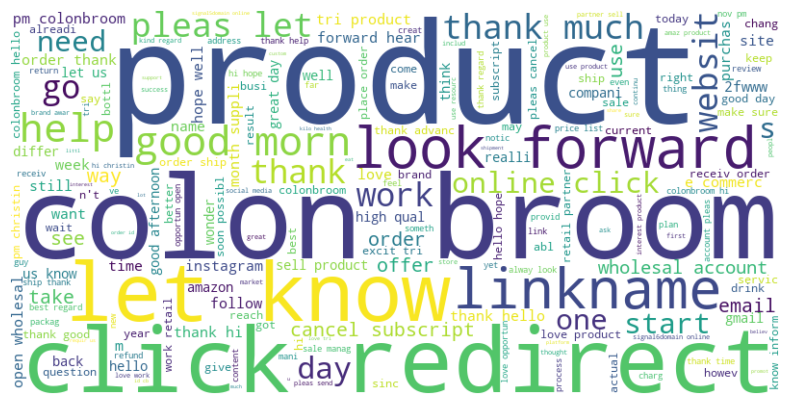

In [92]:
positive_wordcloud = generate_word_cloud(df_label_comparison_positive)

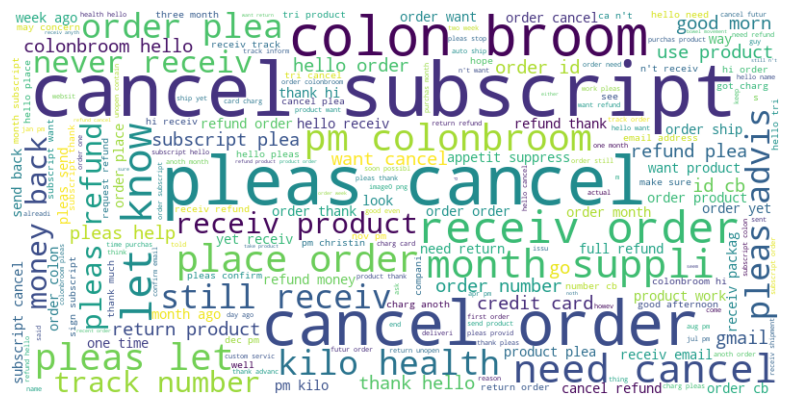

In [93]:
negative_wordcloud = generate_word_cloud(df_label_comparison_negative)

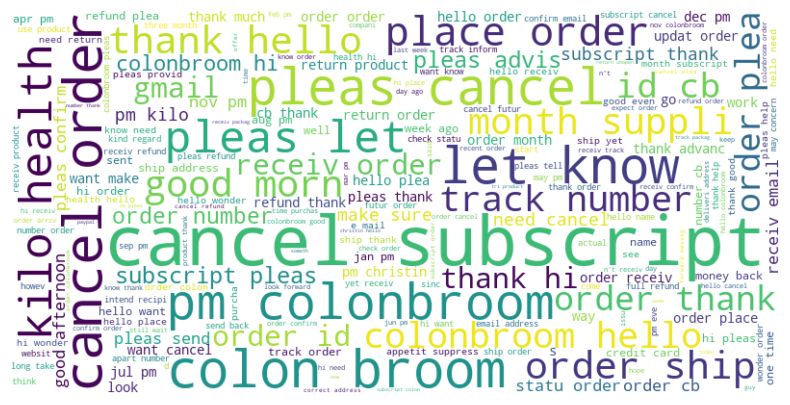

In [94]:
neutral_wordcloud = generate_word_cloud(df_label_comparison_neutral)

Concordance and Collocations of most frequent words in positive, negative and neutral to understand the context, maybe in negative list there are specific phrases that results in the most "negative" feedback which could be used for further predictions

Next steps will include: concordance and collocation, message length / sentiment label analysis, join post purchase data (that is cleaned already) and perform segmentation / linear regression model to analyse if specific words / message length contributes to bigger sub-cancelation / refund / chargeback rate. 